# Master Thesis - Vignoli Lorenzo

---

## 🐙 Helyx training

## ⚙️ Import Libraries

In [1]:
# Libraries
import os
import glob
import random
import warnings
import numpy as np # type: ignore
from sklearn.model_selection import train_test_split # type: ignore

import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
import torch.nn.functional as F # type: ignore
import shutil
import plotly.graph_objects as go # type: ignore
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau # type: ignore
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt # type: ignore
import random
import sys
from torch.amp import GradScaler, autocast # type: ignore

warnings.filterwarnings("ignore")
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## ⏳ Load and process the Data

In [2]:
if True:

    for split in ["train", "val", "test"]:
        shutil.rmtree(f"images/{split}", ignore_errors=True)
        shutil.rmtree(f"labels/{split}", ignore_errors=True)
        shutil.rmtree(f"DELTAL/{split}", ignore_errors=True)
        os.makedirs(f"images/{split}", exist_ok=True)
        os.makedirs(f"labels/{split}", exist_ok=True)
        os.makedirs(f"DELTAL/{split}", exist_ok=True)

    dataset_files = sorted(glob.glob("Dataset*.pt"))
    total_originals = sum([len(torch.load(f)["X_images"]) for f in dataset_files])
    all_indices = np.arange(total_originals)

    train_idx, temp_idx = train_test_split(all_indices, test_size=0.15)
    val_idx, test_idx = train_test_split(temp_idx, test_size=1/3)

    split_map = np.full(total_originals, "", dtype=object)
    split_map[train_idx] = "train"
    split_map[val_idx] = "val"
    split_map[test_idx] = "test"

    global_index = {
        "train": 0,
        "val": 0,
        "test": 0
    }

    current_idx = 0

    for file in dataset_files:

        print(f"\n Processing {file}...")
        data = torch.load(file)
        X_images = data["X_images"]
        y = data["y"]
        X_DELTAL = data["X_DELTAL"]

        for i in range(len(X_images)):

            split = split_map[current_idx]
            image_tensor = X_images[i]
            label_tensor = y[i]
            deltal_tensor = X_DELTAL[i]

            idx_str = f"{global_index[split]:06d}"

            torch.save(image_tensor, f"images/{split}/img_{idx_str}.pt")
            torch.save(label_tensor, f"labels/{split}/label_{idx_str}.pt")
            torch.save(deltal_tensor, f"DELTAL/{split}/deltal_{idx_str}.pt")

            global_index[split] = global_index[split] + 1
            current_idx += 1

            percent = (current_idx / total_originals) * 100
            sys.stdout.write(f"\rProgress: {percent:.2f}%")
            sys.stdout.flush()

        del X_images
        del y
        del X_DELTAL

    print("\n Finished dataset generation.")


 Processing Dataset1.pt...
Progress: 3.85%
 Processing Dataset10.pt...
Progress: 7.69%
 Processing Dataset11.pt...
Progress: 11.54%
 Processing Dataset12.pt...
Progress: 15.38%
 Processing Dataset13.pt...
Progress: 19.23%
 Processing Dataset14.pt...
Progress: 23.08%
 Processing Dataset15.pt...
Progress: 26.92%
 Processing Dataset16.pt...
Progress: 30.77%
 Processing Dataset17.pt...
Progress: 34.62%
 Processing Dataset18.pt...
Progress: 38.46%
 Processing Dataset19.pt...
Progress: 42.31%
 Processing Dataset2.pt...
Progress: 46.15%
 Processing Dataset20.pt...
Progress: 50.00%
 Processing Dataset21.pt...
Progress: 53.85%
 Processing Dataset22.pt...
Progress: 57.69%
 Processing Dataset23.pt...
Progress: 61.54%
 Processing Dataset24.pt...
Progress: 65.38%
 Processing Dataset25.pt...
Progress: 69.23%
 Processing Dataset26.pt...
Progress: 73.08%
 Processing Dataset3.pt...
Progress: 76.92%
 Processing Dataset4.pt...
Progress: 80.77%
 Processing Dataset5.pt...
Progress: 84.62%
 Processing Data

In [3]:
if True:
    label_paths = sorted(glob.glob("labels/train/*.pt"))
    all_labels = torch.stack([torch.load(p).float() for p in label_paths])
    mean = all_labels.mean(dim=0)
    std = all_labels.std(dim=0)
    torch.save({'mean': mean, 'std': std}, 'label_stats.pt')

    del mean, std

In [4]:
class ImageRegressionDataset(Dataset):
    def __init__(self, image_paths, label_paths, split="train"):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = split == "train"

    def __len__(self):
        return len(self.image_paths)

    def apply_blur(self, image, kernel_size=5, sigma_max=7.0):
        sigma = random.uniform(0.0, sigma_max)
        image = image.float().unsqueeze(0) / 255.0
        image = TF.gaussian_blur(image, kernel_size=kernel_size, sigma=sigma)
        return (image.squeeze(0) * 255.0).clamp(0, 255).to(torch.uint8)

    def add_gaussian_noise(self, image, std_max=24.0):
        std = random.uniform(0.0, std_max)
        noise = torch.randn_like(image.float()) * std
        image = image.float() + noise
        return image.clamp(0, 255).to(torch.uint8)

    def apply_color_jitter(self, image, brightness=0.2, contrast=0.3):
        image = image.float().unsqueeze(0) / 255.0
        b = 1.0 + random.uniform(-brightness, brightness)
        c = 1.0 + random.uniform(-contrast, contrast)
        image = TF.adjust_brightness(image, b)
        image = TF.adjust_contrast(image, c)
        return (image.squeeze(0) * 255.0).clamp(0, 255).to(torch.uint8)

    def apply_brightness_shift(self, image, offset_max=0.2):
        offset = random.choice([-offset_max, offset_max])
        image = (image.float() / 255.0 + offset).clamp(0.0, 1.0)
        return (image * 255.0).to(torch.uint8)

    def apply_vignette(self, image, strength_max=0.6):
        strength = strength_max
        H, W = image.shape[1:]
        Y, X = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij')
        radius = torch.sqrt(X**2 + Y**2)
        mask = 1.0 - strength * radius**2
        mask = mask.clamp(0.70, 1.0).unsqueeze(0)
        image = (image.float() / 255.0 * mask).clamp(0.0, 1.0)
        return (image * 255.0).to(torch.uint8)

    def __getitem__(self, idx):
        image = torch.load(self.image_paths[idx]).to(torch.uint8)
        label = torch.load(self.label_paths[idx]).float()

        if self.augment:
            image = self.apply_blur(image)
            image = self.add_gaussian_noise(image)
            image = self.apply_color_jitter(image)
            image = self.apply_brightness_shift(image)
            image = self.apply_vignette(image)

        return image, label

In [5]:
# Load sorted image and label paths
def get_paths(split):
    image_dir = os.path.join("images", split)
    label_dir = os.path.join("labels", split)
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".pt")])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".pt")])
    assert len(image_paths) == len(label_paths)
    return image_paths, label_paths

# Get paths for each split
train_img, train_lbl = get_paths("train")
val_img, val_lbl = get_paths("val")
test_img, test_lbl = get_paths("test")

# Dataset dimensions
print(f"Processed: \n {len(train_img)} training images \n {len(val_img)} validation images \n {len(test_img)} test images")

# Create datasets
train_dataset = ImageRegressionDataset(train_img, train_lbl)
val_dataset = ImageRegressionDataset(val_img, val_lbl)
test_dataset = ImageRegressionDataset(test_img, test_lbl)

# Create dataloaders (ottimizzati)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=12, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        num_workers=12, pin_memory=True, persistent_workers=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         num_workers=12, pin_memory=True, persistent_workers=True)


Processed: 
 22100 training images 
 2600 validation images 
 1300 test images


## ⚓ Network definition

In [6]:
class Markers(nn.Module):
    def __init__(self, alpha=0.18):
        super().__init__()
        self.alpha = alpha

    def rgb_to_hsv(self, x):
        r, g, b = x[:, 0], x[:, 1], x[:, 2]
        maxc, _ = x.max(dim=1)
        minc, _ = x.min(dim=1)
        v = maxc
        eps = 1e-8

        deltac = maxc - minc
        s = deltac / (maxc + eps)
        s[maxc == 0] = 0

        rc = (maxc - r) / (deltac + eps)
        gc = (maxc - g) / (deltac + eps)
        bc = (maxc - b) / (deltac + eps)

        h = torch.zeros_like(maxc)
        h[maxc == r] = (bc - gc)[maxc == r]
        h[maxc == g] = 2.0 + (rc - bc)[maxc == g]
        h[maxc == b] = 4.0 + (gc - rc)[maxc == b]
        h = (h / 6.0) % 1.0
        h[deltac == 0] = 0.0

        return torch.stack([h, s, v], dim=1)

    def forward(self, x):
        hsv = self.rgb_to_hsv(x)
        h, s, v = hsv[:, 0], hsv[:, 1], hsv[:, 2]

        green = ((h > 0.25) & (h < 0.45) & (s > 0.3) & (v > 0.2))
        black = (v < 0.3)
        mask = (green | black).unsqueeze(1)  # [B, 1, H, W]

        x_out = x * self.alpha
        x_out[mask.expand_as(x_out)] = 1.0

        return x_out

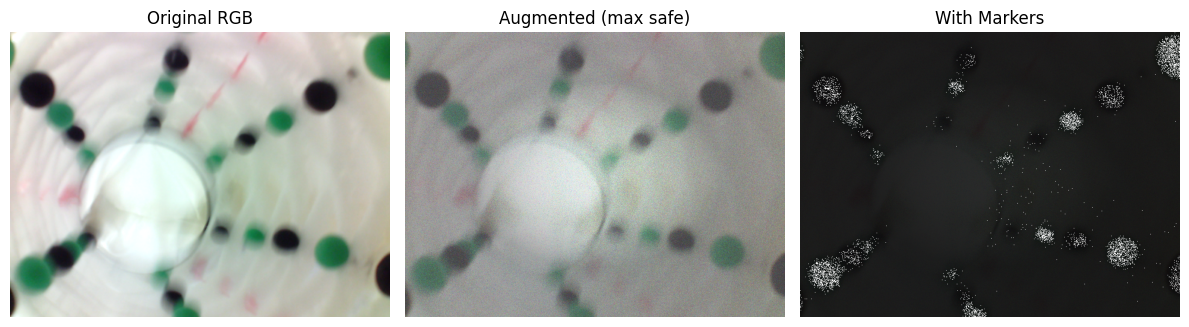

In [7]:
paths = sorted(glob.glob("images/train/*.pt"))
path = random.choice(paths)
image = torch.load(path).float() / 255

def apply_all_augmentations_max(image):
    image = TF.gaussian_blur(image.unsqueeze(0), kernel_size=5, sigma=7.0).squeeze(0)
    noise = torch.randn_like(image) * (25.0 / 255.0)
    image = (image + noise).clamp(0.0, 1.0)
    b = random.choice([1.0 - 0.2, 1.0 + 0.2])
    c = random.choice([1.0 - 0.3, 1.0 + 0.3])
    image = TF.adjust_brightness(image.unsqueeze(0), b).squeeze(0)
    image = TF.adjust_contrast(image.unsqueeze(0), c).squeeze(0)
    offset = random.choice([-0.2, 0.2])
    image = (image + offset).clamp(0.0, 1.0)
    H, W = image.shape[1:]
    Y, X = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij')
    radius = torch.sqrt(X**2 + Y**2)
    mask = 1.0 - 0.7 * radius**2
    mask = mask.clamp(0.70, 1.0).unsqueeze(0)
    image = (image * mask).clamp(0.0, 1.0)
    return image

augmented = apply_all_augmentations_max(image)
markers = Markers()
processed = markers(augmented.unsqueeze(0))[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(augmented.permute(1, 2, 0).cpu())
plt.title("Augmented (max safe)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(processed.permute(1, 2, 0).cpu())
plt.title("With Markers")
plt.axis("off")

plt.tight_layout()
plt.show()


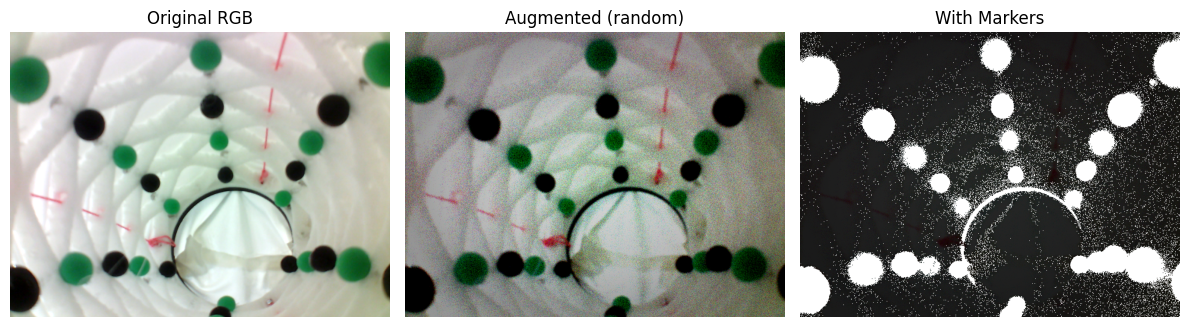

In [8]:
# Show random result with augmentation
paths = sorted(glob.glob("images/train/*.pt"))
path = random.choice(paths)
image = torch.load(path).float() / 255

def apply_all_augmentations_random(image):
    sigma = random.uniform(0.0, 7.0)
    image = TF.gaussian_blur(image.unsqueeze(0), kernel_size=5, sigma=sigma).squeeze(0)

    std = random.uniform(0.0, 25.0) / 255.0
    noise = torch.randn_like(image) * std
    image = (image + noise).clamp(0.0, 1.0)

    b = 1.0 + random.uniform(-0.2, 0.2)
    c = 1.0 + random.uniform(-0.3, 0.3)
    image = TF.adjust_brightness(image.unsqueeze(0), b).squeeze(0)
    image = TF.adjust_contrast(image.unsqueeze(0), c).squeeze(0)

    offset = random.uniform(-0.2, 0.2)
    image = (image + offset).clamp(0.0, 1.0)

    strength = random.uniform(0.0, 0.7)
    H, W = image.shape[1:]
    Y, X = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij')
    radius = torch.sqrt(X**2 + Y**2)
    mask = 1.0 - strength * radius**2
    mask = mask.clamp(0.70, 1.0).unsqueeze(0)
    image = (image * mask).clamp(0.0, 1.0)

    return image

augmented = apply_all_augmentations_random(image)
markers = Markers()
processed = markers(augmented.unsqueeze(0))[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(augmented.permute(1, 2, 0).cpu())
plt.title("Augmented (random)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(processed.permute(1, 2, 0).cpu())
plt.title("With Markers")
plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
from torchvision.models import mobilenet_v2
class NetCamera(nn.Module):
    def __init__(self):
        super().__init__()

        self.markers = Markers()

        base = mobilenet_v2(pretrained=True)

        self.encoder = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        x = x / 255.0
        x = self.markers(x)
        x = self.encoder(x)
        x = self.pool(x)
        x = self.head(x)
        return x

## 😓 Training

In [10]:
model = NetCamera().to(device)

# Check the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Learning rate management
scheduler = LinearLR(optimizer, start_factor = 1e-3, end_factor = 1.0, total_iters = 10)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.9, patience=20, verbose=True)

Total trainable parameters: 2,388,614


In [11]:
best_val_loss = float('inf')
patience = 500
counter = 0

# Normalization parameters
stats = torch.load("label_stats.pt")
mean = stats['mean'].to(device)
std = stats['std'].to(device)

In [ ]:
history_train = []
history_val = []

scaler = GradScaler(device='cuda')

accumulation_steps = len(train_loader) // 5
optimizer.zero_grad()
epochs = 1000

for epoch in range(epochs):
    model.train()
    train_losses = []
    total_batches = len(train_loader)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        with autocast(device_type='cuda'):
            labels_norm = (labels - mean) / std
            preds = model(images)
            loss = criterion(preds, labels_norm)

        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        train_losses.append(loss.item() * accumulation_steps)

        progress = (i + 1) / total_batches * 100
        sys.stdout.write(f"\rEpoch {epoch + 1}: {progress:.1f}%")
        sys.stdout.flush()

        # Perform gradient update at the end of the accumulation steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == total_batches:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    model.eval()
    val_losses = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            with autocast(device_type='cuda'):
                labels_norm = (labels - mean) / std
                preds = model(images)
                loss = criterion(preds, labels_norm)

            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step()

    plateau_scheduler.step(avg_val_loss)
    history_train.append(avg_train_loss)
    history_val.append(avg_val_loss)

    sys.stdout.write("\r")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, "helyx_model_normalized.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

del model
del stats
del mean
del std
del optimizer
del scheduler
del plateau_scheduler
del scaler

Epoch 1 | Train Loss: 1.0246 | Val Loss: 1.0329 | LR: 0.000050
Epoch 2: 40.6%

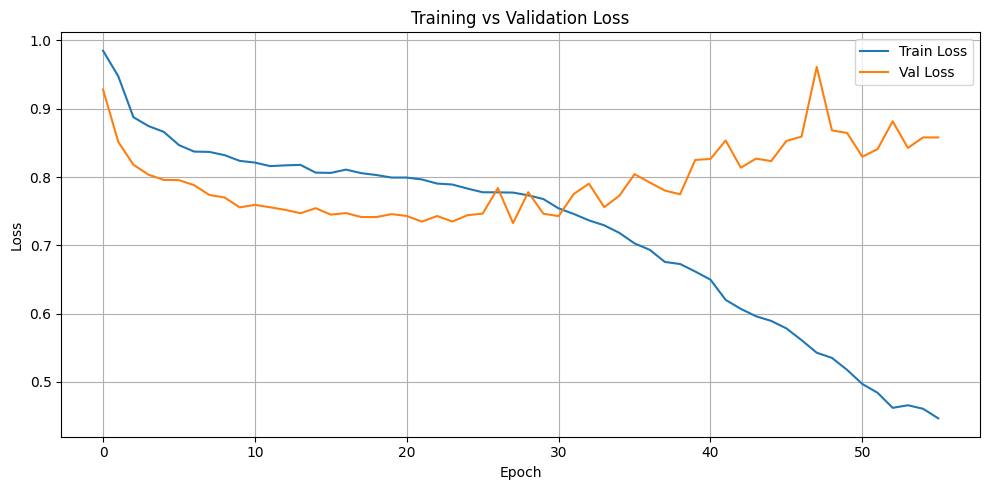

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_train, label='Train Loss')
plt.plot(history_val, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class DenormalizedModel(nn.Module):
    def __init__(self, base_model, mean, std):
        super().__init__()
        self.base_model = base_model
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def forward(self, x):
        out = self.base_model(x)
        return out * self.std + self.mean

In [ ]:
model = torch.load("helyx_model_normalized.pt")
stats = torch.load("label_stats.pt")

# Model and parameters
model = model.to(device)
mean = stats['mean'].to(device)
std = stats['std'].to(device)

# Save final model
final_model = DenormalizedModel(model, mean, std)
torch.save(final_model, "helyx_model.pt")

del final_model
del stats

## ⏰ Testing



Test MSE - normalized: 0.9412
Test MSE - not normalized: 160.4323


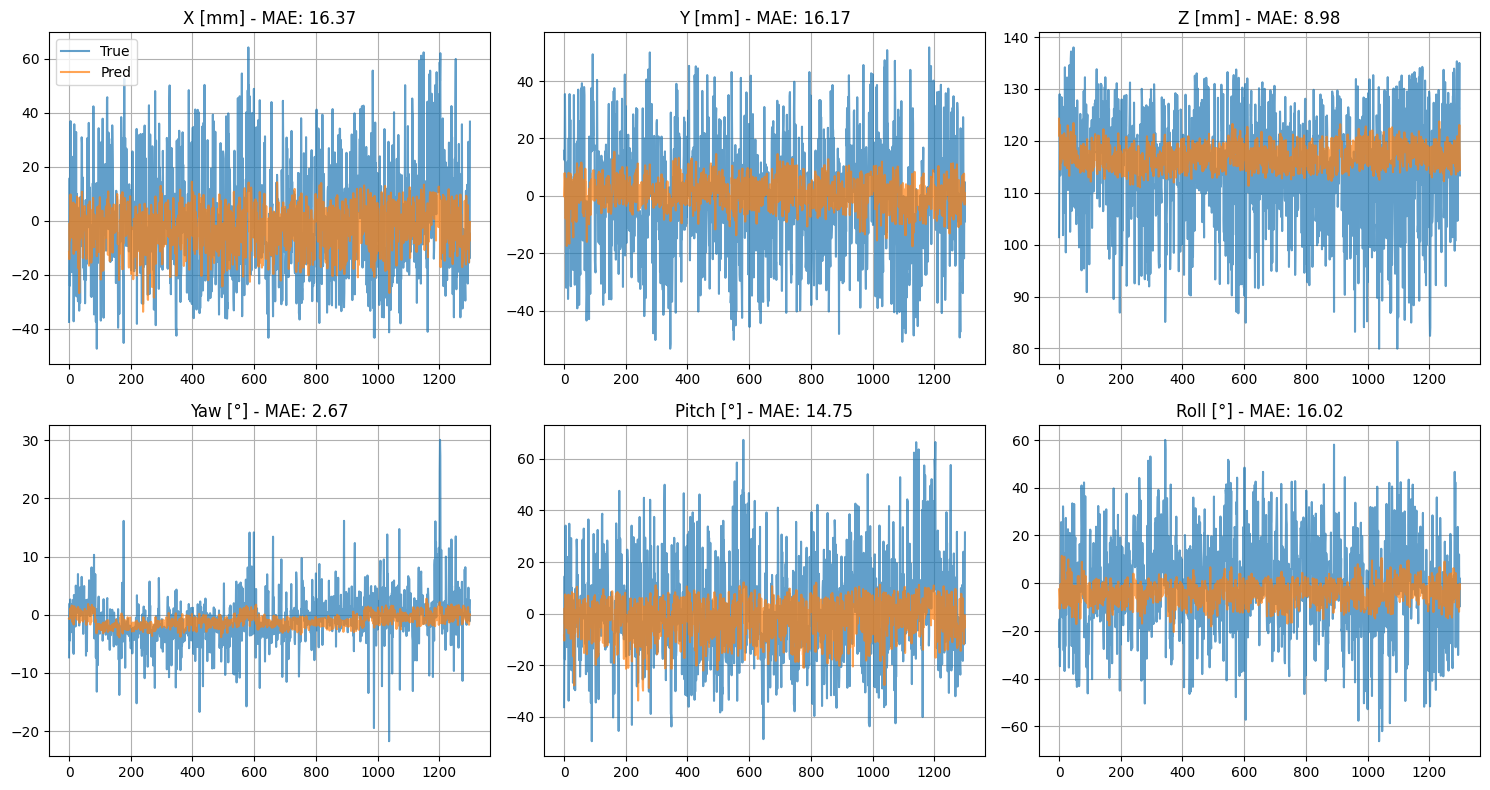

In [ ]:
# Load full model
model = torch.load("helyx_model.pt")
model_normalized = torch.load("helyx_model_normalized.pt")
stats = torch.load("label_stats.pt")
mean = stats['mean'].to(device)
std = stats['std'].to(device)
model = model.to(device)
model_normalized = model_normalized.to(device)
model.eval()
model_normalized.eval()

all_preds = []
all_preds_normalized = []
all_labels = []
all_labels_normalized = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_normalized = (labels - mean) / std

        preds = model(images)
        preds_normalized = model_normalized(images)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_preds_normalized.append(preds_normalized.cpu().numpy())
        all_labels_normalized.append(labels_normalized.cpu().numpy())
        del images, labels, preds, preds_normalized

print("\n")

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds_normalized = np.concatenate(all_preds_normalized, axis=0)
all_labels_normalized = np.concatenate(all_labels_normalized, axis=0)

mse = np.mean((all_preds - all_labels) ** 2)
mse_normalized = np.mean((all_preds_normalized - all_labels_normalized) ** 2)
print(f"Test MSE - normalized: {mse_normalized:.4f}")
print(f"Test MSE - not normalized: {mse:.4f}")

all_preds[:, 3:] = np.rad2deg(all_preds[:, 3:])
all_labels[:, 3:] = np.rad2deg(all_labels[:, 3:])

param_names = ['X [mm]', 'Y [mm]', 'Z [mm]', 'Yaw [°]', 'Pitch [°]', 'Roll [°]']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, ax in enumerate(axes.flatten()):
    mae = np.mean(np.abs(all_preds[:, i] - all_labels[:, i]))  # Calculate MAE
    ax.plot(all_labels[:, i], label='True', alpha=0.7)
    ax.plot(all_preds[:, i], label='Pred', alpha=0.7)
    ax.set_title(f"{param_names[i]} - MAE: {mae:.2f}")
    ax.grid(True)

axes[0, 0].legend()
plt.tight_layout()
plt.show()
